In [ ]:
!pip install diffusers transformers accelerate torch torchvision
!pip install opencv-python pillow numpy


In [ ]:
import torch
from PIL import Image
import numpy as np
import cv2
from diffusers import StableDiffusionInpaintPipeline


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16
)
pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [ ]:
# Load the images
#init_image = Image.open("/content/U1.png").convert("RGB")
mask_image = Image.open("/content/O1.png").convert("RGB")


In [ ]:
mask_np = np.array(mask_image)
gray_mask = cv2.cvtColor(mask_np, cv2.COLOR_RGB2GRAY)


In [ ]:
# Load templates for "U", "o", and upside-down "U"
template_U = cv2.imread("/content/U2.png", 0)
template_o = cv2.imread("/content/O2.png", 0)
template_upside_U = cv2.imread("/content/RU2.png", 0)


In [ ]:
import cv2
import numpy as np

def rotate_template(template, angle):
    """
    Rotate a template by a given angle.

    Args:
        template (numpy.ndarray): The template image to rotate.
        angle (float): The angle to rotate the template.

    Returns:
        numpy.ndarray: The rotated template.
    """
    (h, w) = template.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(template, matrix, (w, h))
    return rotated

def match_symbol(mask, templates, threshold=0.7, rotation_angles=[0, 90, 180, 270]):
    """
    Matches a symbol by comparing the mask with templates, considering rotations.

    Args:
        mask (numpy.ndarray): The grayscale mask image.
        templates (dict): Dictionary of symbol templates.
        threshold (float): Minimum confidence for a match.
        rotation_angles (list): List of angles to rotate each template.

    Returns:
        str: The detected symbol or None if no match.
    """
    best_match = None
    best_score = -1  # Initialize with the worst possible score

    for symbol, template in templates.items():
        for angle in rotation_angles:
            # Rotate the template
            rotated_template = rotate_template(template, angle)

            # Resize the template to match the mask dimensions if necessary
            if rotated_template.shape != mask.shape:
                rotated_template = cv2.resize(rotated_template, (mask.shape[1], mask.shape[0]))

            # Perform template matching
            result = cv2.matchTemplate(mask, rotated_template, cv2.TM_CCOEFF_NORMED)

            # Get the maximum score from the match
            _, max_score, _, _ = cv2.minMaxLoc(result)

            # Debugging: Print match scores for each angle
            print(f"Symbol: {symbol}, Angle: {angle}, Score: {max_score}")

            # Check if this match is better than previous ones
            if max_score > best_score and max_score >= threshold:
                best_score = max_score
                best_match = symbol

    return best_match

# Example usage
# Create or load templates for "U", "Upside Down U", "O", and "Neutral Face"
# These should be grayscale images.
template_U = np.array("/content/U2.png")  # Replace with actual template data
template_upside_U = np.array("/content/RU2.png")  # Replace with actual template data
template_o = np.array("/content/o2.png")  # Replace with actual template data
#template_neutral_face = np.array(...)  # Replace with actual template data

templates = {
    "U": template_U,
    "Upside Down U": template_upside_U,
    "O": template_o,
    #"Neutral Face": template_neutral_face,
}

# Process the grayscale mask
gray_mask = cv2.cvtColor(np.array(mask_image), cv2.COLOR_RGB2GRAY)

# Match the mask with templates
detected_symbol = match_symbol(
    gray_mask,
    templates,
    threshold=0.7,
    rotation_angles=[0, 90, 180, 270]
)

if detected_symbol is None:
    print("No symbol detected or matching confidence too low.")
else:
    print(f"Detected Symbol: {detected_symbol}")


ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
threshold = 0.7  # Adjust based on experimentation
templates = {
    "U": template_U,
    "o": template_o,
    "upside_U": template_upside_U
}
detected_symbol = match_symbol(gray_mask, templates)

if detected_symbol is None:
    print("No symbol detected or matching confidence too low.")
    # Handle the case accordingly
else:
    print(f"Detected Symbol: {detected_symbol}")


Detected Symbol: U


In [ ]:
def get_prompt(symbol):
    mapping = {
        "U": "A portrait of a person smiling",
        "o": "A portrait of a person with a neutral expression",
        "upside_U": "A portrait of a person frowning"
    }
    return mapping.get(symbol, "A portrait of a person")

prompt = get_prompt(detected_symbol)


In [ ]:
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")

image = pipe(prompt).images[0]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

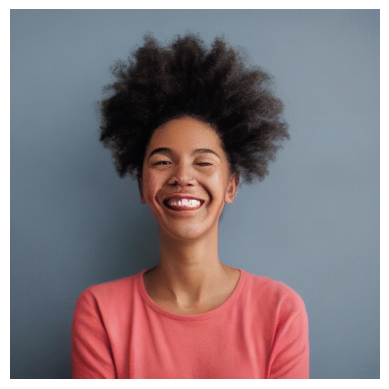

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis('off')  # Optional: Turn off axis
plt.show()